<a href="https://colab.research.google.com/github/ubermenchh/fun/blob/main/diffusers_course/4_diffusion_guidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guidance

In [1]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6

In [2]:
from huggingface_hub import notebook_login

notebook_login()


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [5]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

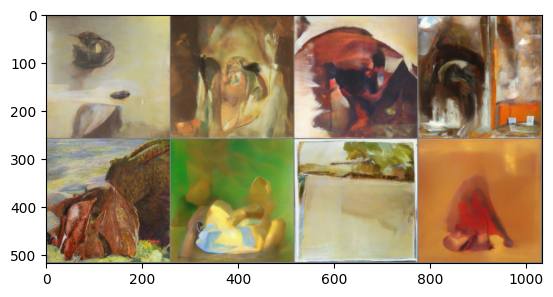

In [6]:
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)['sample']
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [10]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    target = torch.tensor(target_color).to(images.device) * 2 - 1
    target = target[None, :, None, None]
    error = torch.abs(images - target).mean()
    return error

Modified version of Sampling loop,
- Create a new version of x that has requires_grad=True.
- Calculate the denoised version (x0)
- Feed the predicted x0 through our loss function.
- Find the gradient of this loss function with respect to x
- Use this conditioning gradient to modify x before we step with the scheduler, hopefully pushing x in a direction that will lead to lower loss according to out guidance function.

0it [00:00, ?it/s]

0 Loss:  29.906688690185547
10 Loss:  11.391982078552246
20 Loss:  10.485495567321777
30 Loss:  10.549363136291504


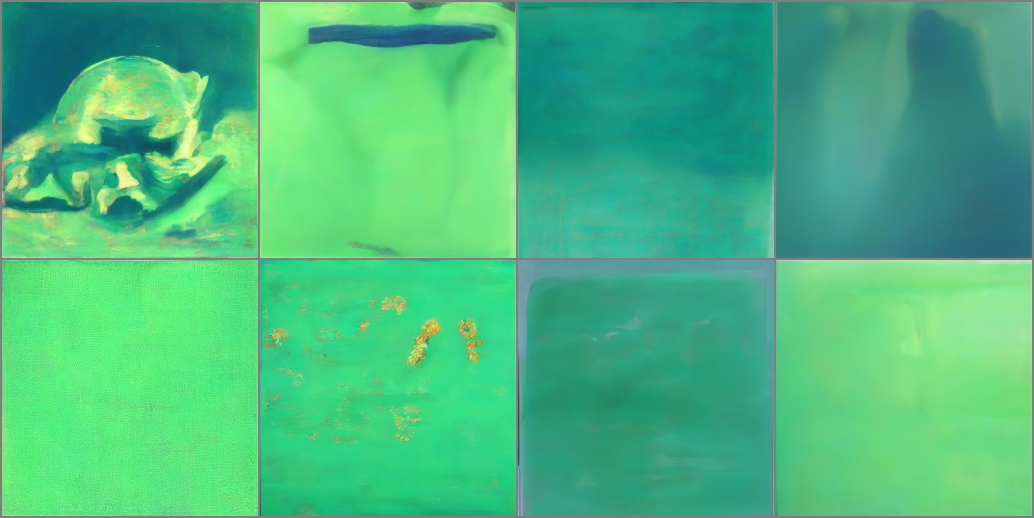

In [7]:
# Variant 1: Shortcut Method

guidance_loss_scale = 40
x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)['sample']

    x = x.detach().requires_grad_()

    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "Loss: ", loss.item())

    cond_grad = -torch.autograd.grad(loss, x)[0]

    x = x.detach() + cond_grad

    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [ ]:
# Variant 2: setting x.required_grad before calculating the model preds

guidance_loss_scale = 40
x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    noise_pred = image_pipe.unet(model_input, t)['sample']

    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "Loss: ", loss.item())

    cond_grad = -torch.autograd.grad(loss, x)[0]

    x = x.detach() + cond_grad

    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

0it [00:00, ?it/s]

OutOfMemoryError: ignored

## Clip Guidance

- CLIP, model created by OpenAI that allows us to compare images to text captions.
- Approach:
    - Embed the text prompt to get a 512-dimensional CLIP embedding of the text.
    - For every step in the diffusion model process:
        - Make several variants of the predicted denoised image (having multiple variations gives a cleaner loss signal)
        - For each one, embed the image with CLIP and compare this embedding with the text embedding of the prompt (using a measure called **'Great Circle Distance Squared'**
    - Calculate the gradient of this loss with respect to the current noisy x and use this gradient to modify x before updating it with the scheduler.

In [7]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
clip_model.to(device)

# transforms to resize and augment an image + normalize to math CLIP's training data
tfms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomAffine(5),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

# define a loss function that takes an image, embeds it and compares with the text
# features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(tfms(image))
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(1), dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
    return dists.mean()

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step:  0 , Guidance Loss:  7.084043979644775
Step:  25 , Guidance Loss:  7.020313262939453


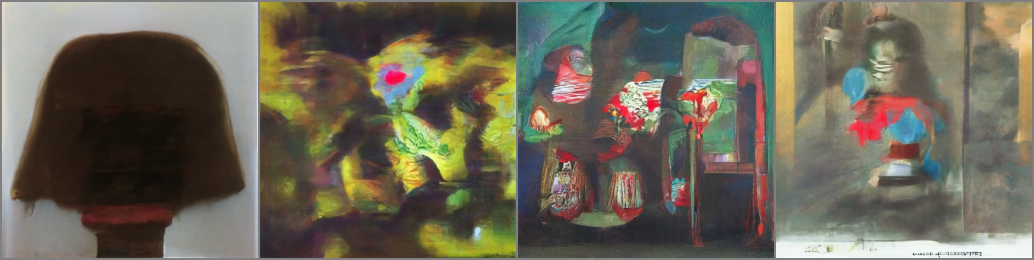

In [8]:
prompt = "Red Rose (sitll life), red flower painting"
guidance_scale = 8
n_cuts = 4

scheduler.set_timesteps(50)

text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)

x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)['sample']

    cond_grad = 0

    for cut in range(n_cuts):
        x = x.detach().requires_grad_()
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        loss = clip_loss(x0, text_features) * guidance_scale

        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step: ", i, ", Guidance Loss: ", loss.item())

    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im*255).astype(np.uint8))

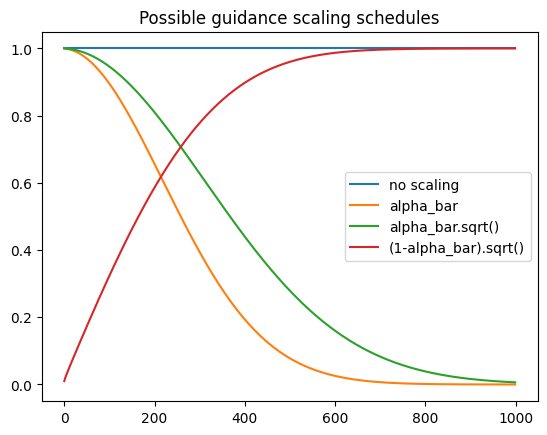

In [10]:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha_bar.sqrt()")
plt.plot(
    [(1 - a).sqrt() for a in scheduler.alphas_cumprod], label="(1-alpha_bar).sqrt()"
)
plt.legend()
plt.title("Possible guidance scaling schedules");

## Custom Sampling Loop as a Gradio Demo

In [15]:
%pip install -q gradio
%pip install typing-extensions --upgrade

In [17]:
!python --version

Python 3.10.12


In [11]:
import gradio as gr
from PIL import Image, ImageColor

def generate(color, guidance_loss_scale):
    target_color = ImageColor.getcolor(color, 'RGB')
    target_color = [a / 255 for a in target_color]
    x = torch.randn(1, 3, 256, 256).to(device)

    for i, t in tqdm(enumerate(scheduler.timesteps)):
        model_input = scheduler.scale_model_input(x, t)
        with torch.no_grad():
            noise_pred = image_pipe.unet(model_input, t)['sample']
        x = x.detach().requires_grad_()
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample
        loss = color_loss(x0, target_color) * guidance_loss_scale
        cond_grad = -torch.autograd.grad(loss, x)[0]
        x = x.detach() + cond_grad
        x = scheduler.step(noise_pred, t, x).prev_sample
    grid = torchvision.utils.make_grid(x, nrow=4)
    im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
    im = Image.fromarray(np.array(im * 255).astype(np.uint8))
    im.save('test.jpg')
    return im

inputs = [
    gr.ColorPicker(label='color', value='55FFAA'),
    gr.Slider(label='guidance_scale', minimum=0, maximum=30, value=3)
]
outputs = gr.Image(label='result')

demo = gr.Interface(
    fn=generate,
    inputs=inputs,
    outputs=outputs,
    examples=[
        ["#BB2266", 3],
        ["#44CCAA", 5],
    ]
)
demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://6c1bb4e47861d5dc5a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6c1bb4e47861d5dc5a.gradio.live
